# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df = df.resample("1H").sum()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


The data only has 1 column, the data type is correct.

In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


From the distribution of data, I think the data is in reasonable range without abnormal values.

## Preparation

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

### Rolling

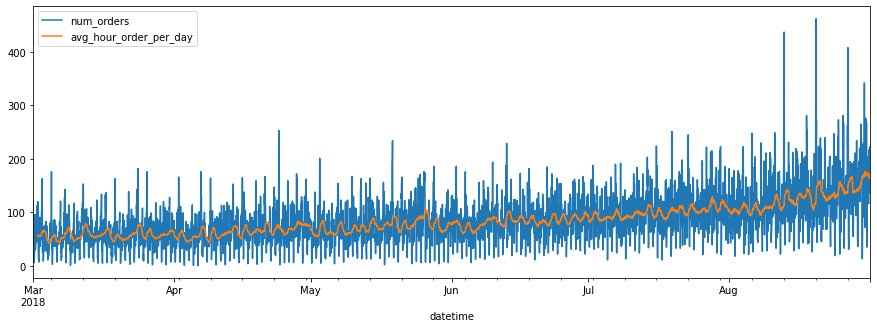

In [7]:
df['avg_hour_order_per_day'] = df.shift().rolling(24).mean()
df.plot(figsize=(15, 5))
plt.show()

Although the data fluctuates quite dramatically. It's not hard to identify there is increasing trend along with time. I'll analyze the trends and seasonality later.

### Creating Features

In [8]:
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

make_features(df, 22)
df.head()

,num_orders,avg_hour_order_per_day,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

### Distribution

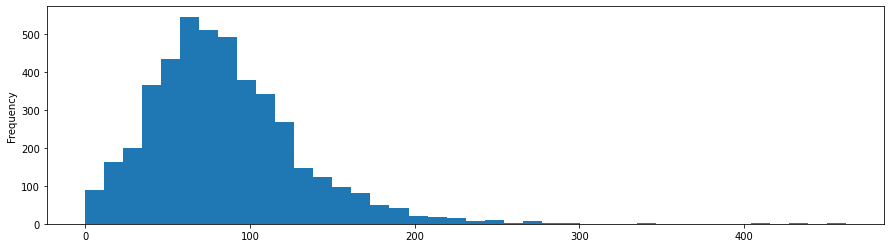

In [9]:
df['num_orders'].plot(kind='hist', bins=40,figsize=(15, 4))
plt.show()

<AxesSubplot:>

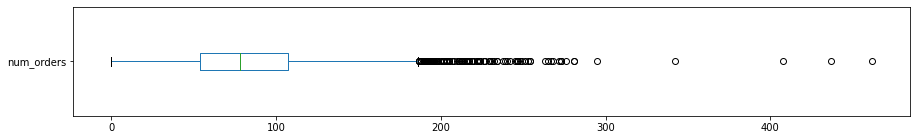

In [10]:
df['num_orders'].plot(kind='box', vert=False, figsize=(15,2))

The distribution of orders by hour obeys normal distribution with slight right skew. The median value is around 80. There are many outliers greater than 190.

### Relationship between orders and lag

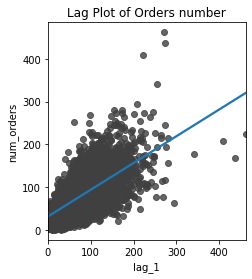

In [11]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='num_orders', data=df[['num_orders', 'lag_1']], ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Orders number');

From the lag plot that number of orders on one hour (`num_orders`) are correlated with number of orders from the previous order (Lag_1). Therefore lag features will be useful.

### Trends and seasonality

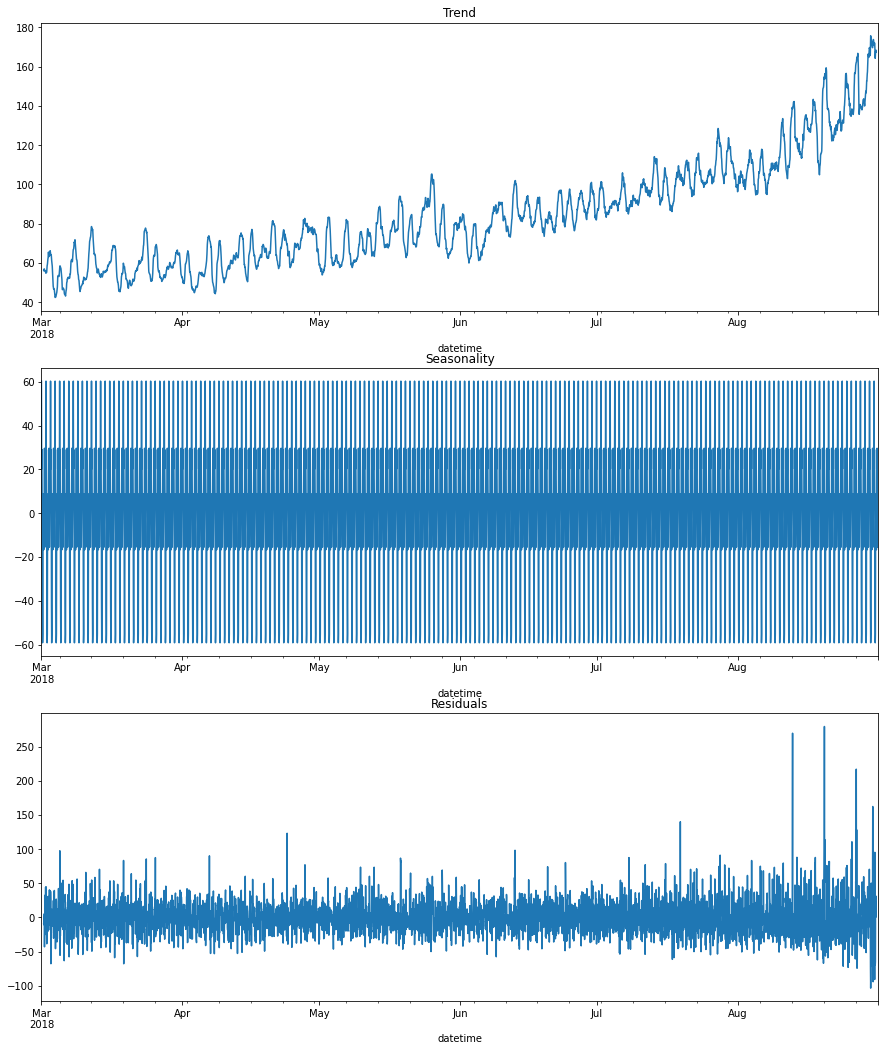

In [12]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(15, 18))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

<AxesSubplot:xlabel='datetime'>

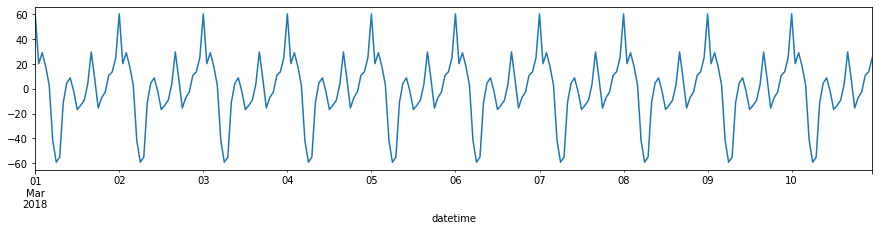

In [13]:
decomposed.seasonal['2018-03-01': '2018-03-10'].plot(figsize=(15,3))

According to the "Trends, Seasonality and Residual" plot, 
* the trends component exhibits a jagged, upward fluctuation. It also means the process is nonsationary.
* The seasonality illustrates repetition of 1 day, the amplitude of the swings is around 120
* The residual is random noise which mean is 0.

## Training

In [14]:
df.head()

,num_orders,avg_hour_order_per_day,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Encoding

#### One-hot encoding

In [15]:
df = df.dropna()
categorical = ['month', 'day', 'hour', 'dayofweek']
encoded_df = pd.get_dummies(df, columns=categorical, drop_first=True)

### Training with default settings

I'll apply `Linear Regression`, `Random Forest`, `XGBoost`, `LightGBM` and `CatBoost` to train the data. 

At first, I'll use the default settings.

In [ ]:
def train_test_prepare(df, target, test_size):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# One-hot encoding dataset for LR and XGBoost
X_train_ohe, y_train_ohe, X_val_ohe, y_val_ohe, X_test_ohe, y_test_ohe = train_test_prepare(encoded_df, 'num_orders', 0.3)
# The original dataset for other models
X_train, y_train, X_val, y_val, X_test, y_test = train_test_prepare(df, 'num_orders', 0.3)

In [ ]:
models_name = []
training_time_list = []
predict_time_list = []
rmse_list = []

def train_pipeline(X_train,X_val, y_train, y_val, model_name, model_obj, scaling=False, lightGBM_params={}):
    models_name.append(model_name)
    start = time.time()
    if scaling is True:
        X_train, X_val = standard_scaling(X_train, X_val)
    if model_name == 'LightGBM' or model_name == 'Optimized LightGBM':
        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(lightGBM_params, train_data)
    elif model_name == 'CatBoost' or model_name == 'Optimized CatBoost':
        model = model_obj
        model.fit(X_train, y_train, verbose=250)
    else:
        model = model_obj
        model.fit(X_train, y_train)
    time_cost = round((time.time() - start), 3)
    training_time_list.append(time_cost) # seperate training and predict time
    predict_start = time.time()
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False) 
    time_cost = round((time.time() - predict_start), 3)
    print(f"The MAE of {model_name} with default setting is: {rmse}")
    predict_time_list.append(time_cost)
    rmse_list.append(rmse)

In [ ]:
model_list_default_training = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
model_objects = [LinearRegression(), RandomForestRegressor(), xgb.XGBRegressor(), None, ctb.CatBoostRegressor()]
for i in range(len(model_list_default_training)):
    if model_list_default_training[i] == 'Linear Regression' or model_list_default_training[i] == 'XGBoost':
        train_pipeline(X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe, model_list_default_training[i], model_objects[i])
    else:
        train_pipeline(X_train, X_val, y_train, y_val, model_list_default_training[i], model_objects[i])

### Fine Tuning

I'll apply the RandomSearchCV to find the best hyperparameters

In [ ]:
def random_optimize(estimator, param_grid, X_train, y_train, n_iter):
    tscv = TimeSeriesSplit(n_splits=5)
    random_search = RandomizedSearchCV(estimator=estimator, 
                                       param_distributions=param_grid, 
                                       n_iter=n_iter, cv=tscv,
                                       scoring='neg_mean_squared_error')
    random_search.fit(X_train, y_train)
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    return random_search.best_params_


In [ ]:
param_grid_rfr = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8]
}
best_params_rfr = random_optimize(RandomForestRegressor(random_state=42), param_grid_rfr, X_train, y_train, n_iter=10)

In [ ]:
#best_params_rfr = {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}
train_pipeline(X_train, X_val, y_train, y_val, "Optimized Random Forest", RandomForestRegressor(random_state=42, **best_params_rfr))

In [ ]:
# CatBoost
param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
}
best_params_cat = random_optimize(ctb.CatBoostRegressor(random_state=42), param_grid_cat, X_train, y_train, n_iter=10)

In [ ]:
#best_params_cat = {'learning_rate': 0.1, 'iterations': 300, 'depth': 4}
train_pipeline(X_train, X_val, y_train, y_val, "Optimized CatBoost", ctb.CatBoostRegressor(random_state=42, **best_params_cat))

In [ ]:
# LightGBM
param_grid_light = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': range(10, 200),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}
best_params_light = random_optimize(lgb.LGBMRegressor(random_state=42), param_grid_light, X_train, y_train, n_iter=10)

In [ ]:
train_pipeline(X_train, X_val, y_train, y_val, 'Optimized LightGBM', None, lightGBM_params=best_params_light) 


In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
}
best_params_xgb = random_optimize(xgb.XGBRegressor(random_state=42), param_grid_xgb, X_train_ohe, y_train_ohe, n_iter=10)

In [ ]:
train_pipeline(X_train, X_val, y_train, y_val, 'Optimized XGBoost', xgb.XGBRegressor(random_state=42, **best_params_xgb))


In [ ]:
results = pd.DataFrame({'Model': models_name, 'RMSE': rmse_list, 'Training Time Cost (second)': training_time_list, 'Predict Time Cost (second)': predict_time_list})
results

According to the result table, `LightGBM` obtain the lowest RMSE which is 27.84, while other models get the RMSE between 28 and 31. Additionally, for the training and predict time cost, `LightGBM` has the second fastest time cost, which sum of training and predict time is less than 0.9 second.

Therefore I choose `LightGBM` as the final model.

## Testing

In [19]:
X = df.drop("num_orders", axis=1)
y = df["num_orders"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train({}, train_data)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"The RMSE of test set is: {rmse}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 3733, number of used features: 27
[LightGBM] [Info] Start training from score 76.478436
The RMSE of test set is: 44.403227657591465


> I did updated the RMSE metrics, but the notebook didn't save to the latest version. But your advice of concatenated train and validation set make sense. Thank you.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48